In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Base Metric
from metrics.base.dice_score_coefficient import dsc

# Match
from metrics.part_aware.partpq import create_match_dict, get_all_matches, optimal_matching, thing_cls_counts, thing_cls_scores, stuff_cls_scores, PartPQ

# tools
from metrics.tools.labelling import label

import warnings

warnings.filterwarnings("ignore")

# Case Details

In [2]:
# Dummy Case
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Stuff Classes first (lowest hirearchy)
pred[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred[1:6, 1:6] = 1
pred[7:20, 7:20] = 1
pred[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred[2:5, 2:5] = 2
pred[2:5, 8:10] = 2
pred[8:12, 8:12] = 2
pred[14:19, 14:19] = 2
pred[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
gt[1:30, 1:30] = 4

# Thing Classes next
gt[1:6, 1:6] = 1
gt[7:20, 7:20] = 1
gt[22:27, 22:27] = 3

# Part Classes last
gt[2:5, 2:5] = 2
gt[14:19, 14:19] = 2

# Class definitions
stuff_cls_list = [4]
thing_cls_list = [1, 3]
part_cls_list = [2]

#! Unfortunately, I am not sure how to avoid defining this hierarchy style thing. But we dont need to because the output is expected to be in hierarchy already

# Visualise sample case

In [3]:
def plot_case(pred, gt, stuff_cls_list, thing_cls_list, part_cls_list, class_names_dict=None):

    sns.set(style="whitegrid", context="talk")
    plt.rcParams["axes.edgecolor"] = "0.2"
    plt.rcParams["axes.linewidth"] = 1.5

    pred_np = pred.cpu().numpy() if hasattr(pred, "cpu") else pred
    gt_np = gt.cpu().numpy() if hasattr(gt, "cpu") else gt

    all_classes = sorted(set(thing_cls_list + part_cls_list + stuff_cls_list))
    max_class_id = max(all_classes) + 1  # max possible ID + 1

    background_color = [0.97, 0.97, 0.97, 1]
    pastel_colors = [
        [0.85, 0.41, 0.43, 1.0],
        [0.88, 0.58, 0.40, 1.0],
        [0.92, 0.77, 0.5, 1.0],
        [0.6, 0.75, 0.55, 1.0],
        [0.55, 0.67, 0.83, 1.0],
        [0.65, 0.5, 0.75, 1.0],
        [0.75, 0.55, 0.75, 1.0],
        [0.7, 0.9, 0.9, 1.0],
    ]

    # Create color mapping that works with any class IDs
    class_colors = [background_color] * max_class_id  # Initialize with background color
    color_idx = 0
    for class_id in all_classes:
        if color_idx < len(pastel_colors):
            class_colors[class_id] = pastel_colors[color_idx]
        else:
            # Generate additional colors if needed
            h = (color_idx * 0.618033988749895) % 1  # Golden ratio method for color distribution
            r, g, b = plt.cm.hsv(h)
            class_colors[class_id] = [r, g, b, 1.0]
        color_idx += 1
    
    # Custom colormap for class visualization
    class_cmap = mcolors.ListedColormap(class_colors)
    
    # Custom normalization to map each class ID to its specific color
    class_bounds = np.arange(-0.5, max_class_id + 0.5, 1)
    class_norm = mcolors.BoundaryNorm(class_bounds, len(class_colors))

    # TP / FP / FN Confusion map colors
    tp_color = [0.77, 0.60, 0.43, 1.0]  # True Positive
    fp_color = [0.95, 0.70, 0.80, 1.0]  # False Positive
    fn_color = [0.85, 0.71, 0.85, 1.0]  # False Negative

    # Create confusion visualization
    confusion_vis = np.zeros_like(pred_np)
    confusion_colors = [background_color] * (3 * max_class_id)  # Initialize with background

    # For each class, set colors for TP, FP, FN
    for i, c in enumerate(all_classes):
        # Find TP, FP, FN for each class
        tp = (pred_np == c) & (gt_np == c)
        fp = (pred_np == c) & (gt_np != c)
        fn = (pred_np != c) & (gt_np == c)

        # Set values in confusion visualization
        confusion_vis[tp] = c
        confusion_vis[fp] = c + max_class_id
        confusion_vis[fn] = c + 2 * max_class_id

        # Set colors for each case
        confusion_colors[c] = tp_color
        confusion_colors[c + max_class_id] = fp_color
        confusion_colors[c + 2 * max_class_id] = fn_color

    confusion_cmap = mcolors.ListedColormap(confusion_colors)
    confusion_bounds = np.arange(-0.5, 3 * max_class_id + 0.5, 1)
    confusion_norm = mcolors.BoundaryNorm(confusion_bounds, len(confusion_colors))

    # Create figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(30, 8))
    plt.subplots_adjust(wspace=0.4)

    # Plot prediction, ground truth, and confusion map
    ax[0].imshow(pred_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[0].set_title("Prediction")

    ax[1].imshow(gt_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[1].set_title("Ground Truth")

    ax[2].imshow(confusion_vis, cmap=confusion_cmap, norm=confusion_norm, interpolation="nearest")
    ax[2].set_title("Confusion Map")

    # Format axes with grids
    for a in ax:
        h, w = pred_np.shape
        a.set_xticks(np.arange(-0.5, w, 1), minor=True)
        a.set_yticks(np.arange(-0.5, h, 1), minor=True)
        a.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
        a.tick_params(which='minor', bottom=False, left=False)
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_color("#dddddd")

    # Create legend
    if class_names_dict is None:
        class_names_dict = {cid: f"Class {cid}" for cid in all_classes}

    color_legend_patches = [
        plt.Line2D([0], [0], marker='s', color='w', label=class_names_dict[cid],
                   markerfacecolor=tuple(class_colors[cid][:3]), markersize=15)
        for cid in all_classes
    ]
    ax[1].legend(handles=color_legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

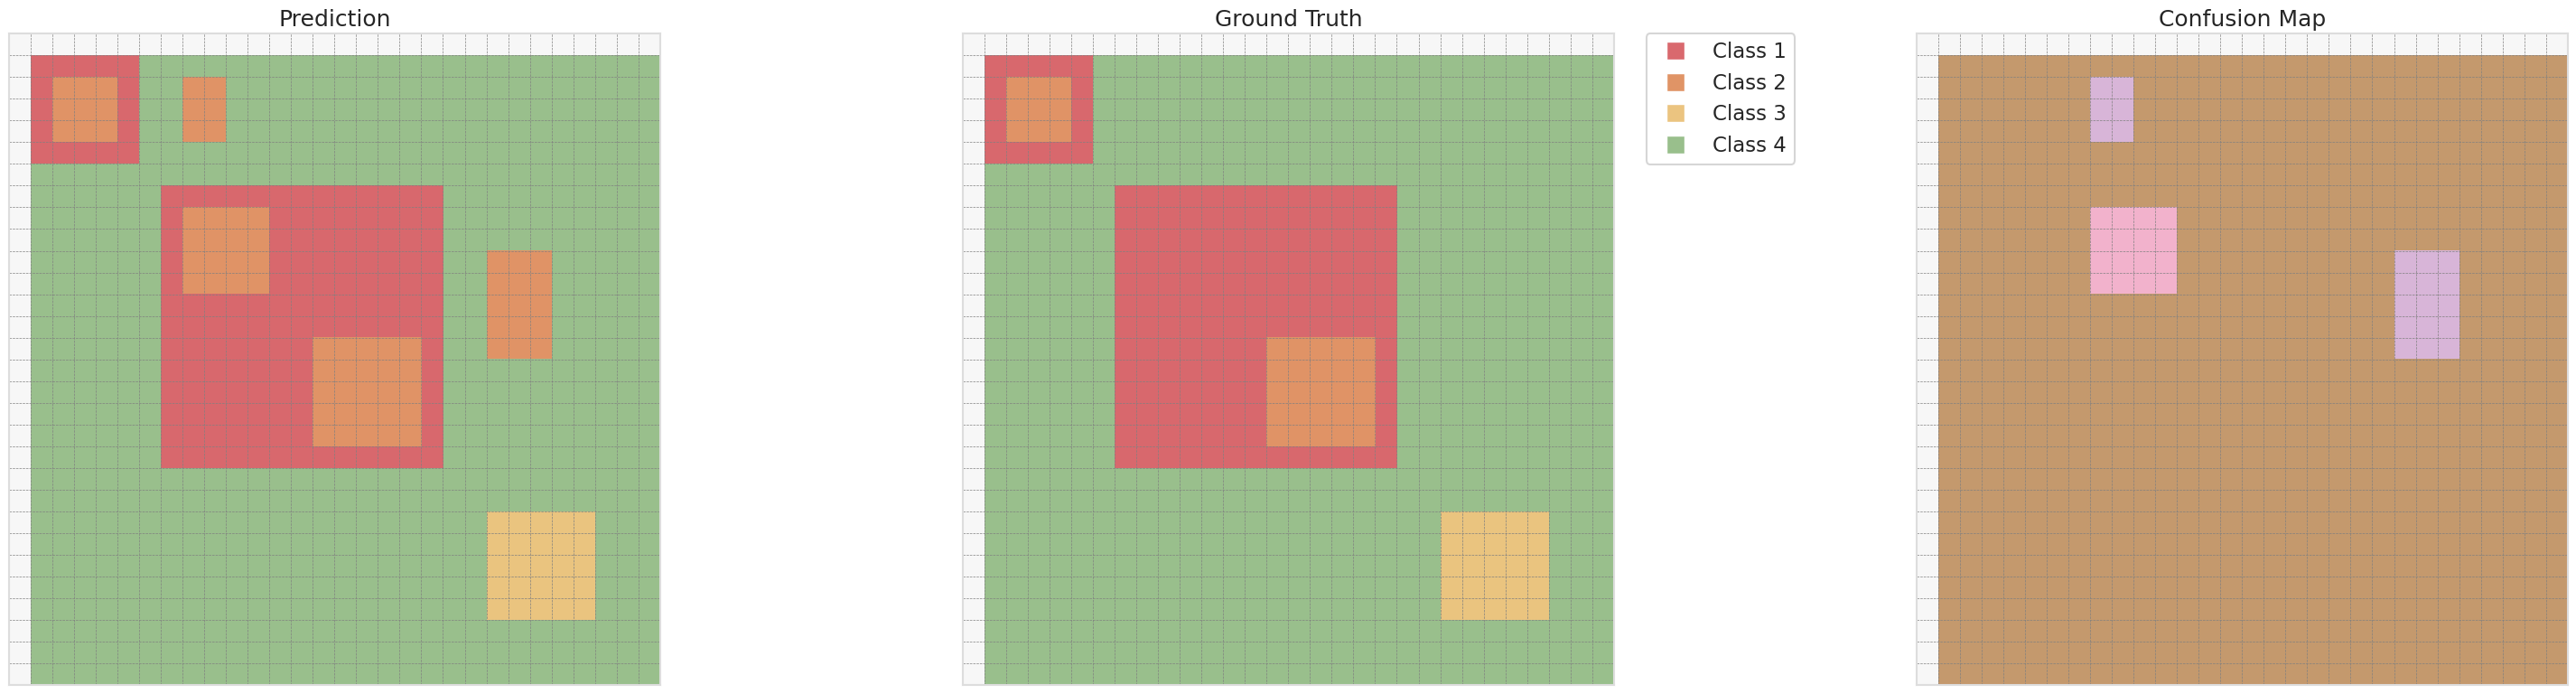

In [4]:
plot_case(pred, gt, stuff_cls_list=stuff_cls_list, thing_cls_list=thing_cls_list, part_cls_list=part_cls_list)

# Labelling the inputs

In [5]:
pred_one_hot_cc = label(pred, 5)
gt_one_hot_cc = label(gt, 5)

# Matching Step

In [6]:
# Forming the match dictionary
match_dictionary = create_match_dict(
    pred_one_hot_cc=pred_one_hot_cc,
    gt_one_hot_cc=gt_one_hot_cc,
    metric=dsc,
    thing_cls_list=thing_cls_list,
    part_cls_list=part_cls_list,
)

print("=" * 80)
print("MATCHING RESULTS")
print("=" * 80)

"""
Only thing classes have to be matched. 
Only those part instances within a thing instance have to be accounted for, as they are important in the final calculation.
"""

# As we are following one-to-one matching, we can use the Hungarian algorithm to find the optimal assignment.
optimal_matches_per_class = {}

for class_index, matches_for_current_class in match_dictionary.items():
    print(f"\nCLASS {class_index}")
    print("-" * 80)

    # Get all candidate panoptic matches and collective part scores for this class
    candidate_panoptic_matches, candidate_part_matches = get_all_matches(matches_for_current_class)
    
    # THING MATCHES (including FPs and FNs)
    print(f"\nTHING MATCHES (Class {class_index}):")
    if candidate_panoptic_matches:
        processed_pairs = set() # Keep track of pairs to avoid double printing FP/FN messages if redundant
        has_matches = False
        for predicted_id, ground_truth_id, match_score in candidate_panoptic_matches:
            pair = (predicted_id, ground_truth_id)
            if pair in processed_pairs:
                continue

            if predicted_id is None:
                print(f"  MISSED: Ground Truth component {ground_truth_id} was not detected (False Negative)")
            elif ground_truth_id is None:
                print(f"  EXTRA: Predicted component {predicted_id} has no corresponding ground truth (False Positive)")
            else:
                print(f"  Pred {predicted_id} <-> GT {ground_truth_id} | Dice: {match_score:.4f}")
                has_matches = True
            processed_pairs.add(pair)
        if not has_matches and not any(p is None or g is None for p,g,_ in candidate_panoptic_matches):
             print("  No candidate panoptic matches found, only potential FPs/FNs listed above (if any).")
    else:
        # Check if there are unmatched components in GT or Pred based on the source dict
        gt_ids_in_class = set(matches_for_current_class.get("gt_to_pred", {}).keys())
        pred_ids_in_class = set(matches_for_current_class.get("pred_to_gt", {}).keys())
        if not gt_ids_in_class and not pred_ids_in_class:
            print("  No ground truth or predicted components found for this class.")
        else:
            print("  No overlapping candidate matches found for this class.")

    # Corresponding PART MATCHES
    print(f"\nRESPECTIVE PART SCORES: (Class {class_index}):")
    if candidate_part_matches:
        for predicted_id, ground_truth_id, part_class_index, part_score in candidate_part_matches:
            print(f"  (Pred {predicted_id} <-> GT {ground_truth_id}) | Part Class {part_class_index} | Collective Score: {part_score:.4f}")
    else:
        print("  No collective part scores found for this class.")

    # Calculate optimal one-to-one assignment using Hungarian algorithm
    optimal_assignments_for_class = optimal_matching(candidate_panoptic_matches, candidate_part_matches)
    optimal_matches_per_class[class_index] = optimal_assignments_for_class

    print(f"\nOPTIMAL ASSIGNMENTS (Class {class_index}):")
    if optimal_assignments_for_class:
        for assignment in optimal_assignments_for_class:
            predicted_id = assignment[0]
            ground_truth_id = assignment[1]
            panoptic_score = assignment[2]
            # Check if part scores are included (tuple length is 4)
            if len(assignment) == 4:
                part_scores_dict = assignment[3]
                part_info = f" | Part Scores: {part_scores_dict}" # Or format more nicely
            else:
                part_info = ""
            print(f"  Optimal: Predicted {predicted_id} <-> Ground Truth {ground_truth_id} | Panoptic Score: {panoptic_score:.4f}{part_info}")
    else:
        print("  No optimal matches found for this class (might be only FPs or FNs).")


MATCHING RESULTS

CLASS 1
--------------------------------------------------------------------------------

THING MATCHES (Class 1):
  Pred 1 <-> GT 1 | Dice: 1.0000
  Pred 2 <-> GT 2 | Dice: 0.9412

RESPECTIVE PART SCORES: (Class 1):
  (Pred 1 <-> GT 1) | Part Class 2 | Collective Score: 1.0000
  (Pred 2 <-> GT 2) | Part Class 2 | Collective Score: 0.7576

OPTIMAL ASSIGNMENTS (Class 1):
  Optimal: Predicted 1 <-> Ground Truth 1 | Panoptic Score: 1.0000 | Part Scores: {2: 1.0}
  Optimal: Predicted 2 <-> Ground Truth 2 | Panoptic Score: 0.9412 | Part Scores: {2: 0.7575757503509521}

CLASS 3
--------------------------------------------------------------------------------

THING MATCHES (Class 3):
  Pred 1 <-> GT 1 | Dice: 1.0000

RESPECTIVE PART SCORES: (Class 3):
  No collective part scores found for this class.

OPTIMAL ASSIGNMENTS (Class 3):
  Optimal: Predicted 1 <-> Ground Truth 1 | Panoptic Score: 1.0000


# THING + PART CLASS SCORES

In [7]:
print("=" * 80)
print("FINAL THING CLS SCORES (ACCOUNTING FOR PARTS)")
print("=" * 80)

average_quality_per_class = {}

# Iterate through the optimal matches we stored earlier
for class_index, current_optimal_matches in optimal_matches_per_class.items():
    # Only calculate quality contribution for panoptic classes
    if class_index not in thing_cls_list:
        continue

    print(f"\nCLASS {class_index}")
    print("-" * 80)
    
    average_match_quality_for_class, individual_match_qualities = thing_cls_scores(current_optimal_matches)

    average_quality_per_class[class_index] = average_match_quality_for_class

    if not current_optimal_matches:
        print(f"  No optimal matches found - Average Match Quality Contribution = 0.0")
        continue

    # Print details for each optimally matched pair based on stored data
    for i, current_match_tuple in enumerate(current_optimal_matches):
        quality_score_for_this_match = individual_match_qualities[i]
        predicted_component_id = current_match_tuple[0]
        ground_truth_component_id = current_match_tuple[1]
        current_panoptic_score = current_match_tuple[2]

        print(f"  Match {i+1}: Predicted {predicted_component_id} <-> Ground Truth {ground_truth_component_id}")
        print(f"    - Thing Component Score: {current_panoptic_score:.4f}")

        # Check if part scores are included in the tuple
        if len(current_match_tuple) == 4:
            current_part_scores = current_match_tuple[3]
            scores_for_quality_calculation = [current_panoptic_score] + list(current_part_scores.values())

            if current_part_scores:
                 print(f"    - Part Component Scores:")
                 for part_class_index, part_component_score in current_part_scores.items():
                     print(f"      - Part Class {part_class_index}: {part_component_score:.4f}")
                 print(f"    - Total Score: {quality_score_for_this_match:.4f} (Average of {len(scores_for_quality_calculation)} scores)")
            else:
                 print(f"    - No part scores found for this match pair, though parts were checked.")
                 print(f"    - Total Score: {quality_score_for_this_match:.4f} (Based on panoptic score only)")

        else: # Match tuple only had panoptic info
            print(f"    - No part component scores included in this match data.")
            print(f"    - Total Score: {quality_score_for_this_match:.4f} (Based on panoptic score only)")

    # Print the final score for the class
    print(f"FINAL SCORE: {average_match_quality_for_class:.4f}")

FINAL THING CLS SCORES (ACCOUNTING FOR PARTS)

CLASS 1
--------------------------------------------------------------------------------
  Match 1: Predicted 1 <-> Ground Truth 1
    - Thing Component Score: 1.0000
    - Part Component Scores:
      - Part Class 2: 1.0000
    - Total Score: 1.0000 (Average of 2 scores)
  Match 2: Predicted 2 <-> Ground Truth 2
    - Thing Component Score: 0.9412
    - Part Component Scores:
      - Part Class 2: 0.7576
    - Total Score: 0.8494 (Average of 2 scores)
FINAL SCORE: 0.9247

CLASS 3
--------------------------------------------------------------------------------
  Match 1: Predicted 1 <-> Ground Truth 1
    - Thing Component Score: 1.0000
    - No part component scores included in this match data.
    - Total Score: 1.0000 (Based on panoptic score only)
FINAL SCORE: 1.0000


# STUFF CLASS SCORES

STUFF CLS SCORE

CLASS 4
--------------------------------------------------------------------------------


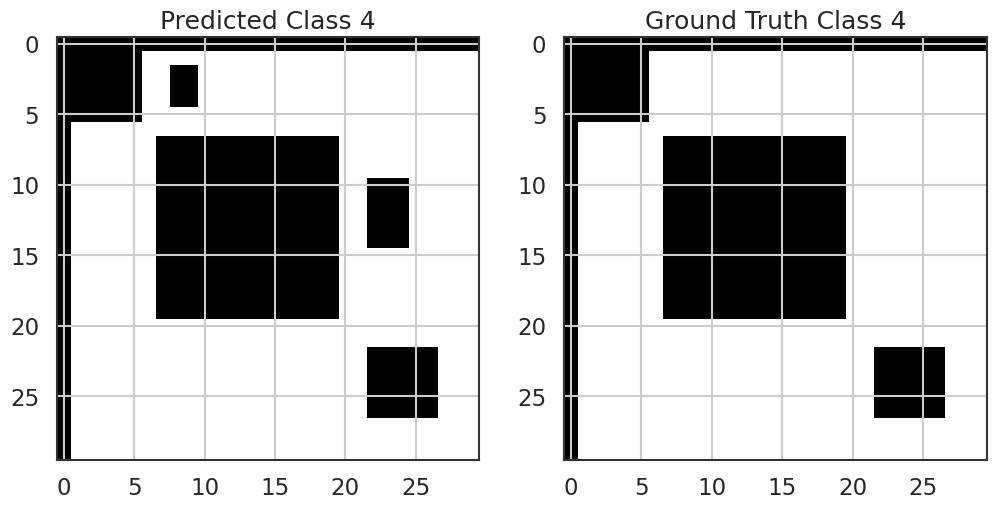

  SCORE: 0.9828

 TOTAL SCORE: 0.9828

 TOTAL SCORE: 0.9828


In [8]:
print("=" * 80)
print("STUFF CLS SCORE")
print("=" * 80)

stuff_cls_scores = 0.0
# calculate the average metric score across all stuff classes
if stuff_cls_list is not None:
    for cls in stuff_cls_list:
        print(f"\nCLASS {cls}")
        print("-" * 80)
        # calculate the simple metric score for each class
        score = dsc(pred_one_hot_cc[cls], gt_one_hot_cc[cls])
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(pred_one_hot_cc[cls].cpu().numpy(), cmap='gray', interpolation='nearest')
        ax[0].set_title(f"Predicted Class {cls}")
        ax[1].imshow(gt_one_hot_cc[cls].cpu().numpy(), cmap='gray', interpolation='nearest')
        ax[1].set_title(f"Ground Truth Class {cls}")
        plt.show()
        print(f"  SCORE: {score:.4f}")

        stuff_cls_scores += score

    #! If both pred and gt are empty, this will be 1.0. If either are empty, it will be 0.0.
    stuff_cls_scores /= len(stuff_cls_list)
else:
    print("No stuff classes provided for scoring.")
    
print(f"\n TOTAL SCORE: {stuff_cls_scores:.4f}")

# COUNTING METRICS

In [9]:
print("=" * 80)
print("COUNTING METRICS")
print("=" * 80)

"""
Get the counting metrics based on the thing classes.
"""

thing_counts_per_class = thing_cls_counts(
    pred_one_hot_cc=pred_one_hot_cc,
    gt_one_hot_cc=gt_one_hot_cc,
    metric='dsc', # Ensure metric matches
    thing_cls_list=thing_cls_list,
    part_cls_list=part_cls_list
)

total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0

if not thing_counts_per_class[0]:
    print("  No panoptic classes found or processed for counts.")
else:
    for class_index, (tp, fp, fn) in thing_counts_per_class[0].items():
        print(f"\nCLASS {class_index}")
        print("-" * 80)
        print(f"  True Positives (TP): {tp}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        total_true_positives += tp
        total_false_positives += fp
        total_false_negatives += fn

print("\nOVERALL COUNTS:")
print(f"Total True Positives: {total_true_positives}")
print(f"Total False Positives: {total_false_positives}")
print(f"Total False Negatives: {total_false_negatives}")


COUNTING METRICS

CLASS 1
--------------------------------------------------------------------------------
  True Positives (TP): 2
  False Positives (FP): 0
  False Negatives (FN): 0

CLASS 3
--------------------------------------------------------------------------------
  True Positives (TP): 1
  False Positives (FP): 0
  False Negatives (FN): 0

OVERALL COUNTS:
Total True Positives: 3
Total False Positives: 0
Total False Negatives: 0

CLASS 1
--------------------------------------------------------------------------------
  True Positives (TP): 2
  False Positives (FP): 0
  False Negatives (FN): 0

CLASS 3
--------------------------------------------------------------------------------
  True Positives (TP): 1
  False Positives (FP): 0
  False Negatives (FN): 0

OVERALL COUNTS:
Total True Positives: 3
Total False Positives: 0
Total False Negatives: 0


In [10]:
print("=" * 80)
print("FINAL PART PQ CALCULATION")
print("=" * 80)

# Numerator: Sum of Thing (accounting for parts) Scores + Stuff Class Scores
thing_numerator_score = (sum(average_quality_per_class.values()) / len(average_quality_per_class))
print(f"\n  Total Thing Class Score =  Total Thing Class Score: {sum(average_quality_per_class.values()):.4f} / Number of Classes: {len(average_quality_per_class)} = {thing_numerator_score:.4f}")
stuff_numerator_score = stuff_cls_scores
print(f"  Mean Stuff Class Score: {stuff_numerator_score:.4f}")

# Denominator: Total TPs + FPs + FNs
part_pq_denominator = total_true_positives + total_false_positives + total_false_negatives
print(f"\n  Total Count Metrics = TPs + FPs + FNs: {total_true_positives} + {total_false_positives} + {total_false_negatives} = {part_pq_denominator}")

# Final Part PQ Calculation
part_pq_score = (thing_numerator_score + stuff_numerator_score) / part_pq_denominator
print(f"\n  Final Part PQ Score = (Thing Class Score + Stuff Class Score) / (TPs + FPs + FNs): ({thing_numerator_score:.4f} + {stuff_numerator_score:.4f}) / {part_pq_denominator} = {part_pq_score:.4f}")
print(f"\nFINAL PART PQ SCORE: {part_pq_score:.4f}")

# Comparing with complete function:
direct_part_pq_verification = PartPQ(
    pred_one_hot_cc=pred_one_hot_cc,
    gt_one_hot_cc=gt_one_hot_cc,
    metric='dsc', # Make sure this matches the metric used throughout
    stuff_cls_list=stuff_cls_list,
    thing_cls_list=thing_cls_list,
    part_cls_list=part_cls_list
)
print(f"Direct PartPQ Calculation: {direct_part_pq_verification:.4f}")

FINAL PART PQ CALCULATION

  Total Thing Class Score =  Total Thing Class Score: 1.9247 / Number of Classes: 2 = 0.9623
  Mean Stuff Class Score: 0.9828

  Total Count Metrics = TPs + FPs + FNs: 3 + 0 + 0 = 3

  Final Part PQ Score = (Thing Class Score + Stuff Class Score) / (TPs + FPs + FNs): (0.9623 + 0.9828) / 3 = 0.6484

FINAL PART PQ SCORE: 0.6484
Direct PartPQ Calculation: 0.6484
